In [1]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import import_ipynb
import numpy as np
import cv2

import PlotsConfig as conf

importing Jupyter notebook from PlotsConfig.ipynb


In [2]:
# TODO: import the data cell, explain what the damn data contains

In [3]:
# Importing the data

dfs = [pd.read_csv(conf.main_path + f"CSV/{f_name}.csv") 
       for f_name in ['data8am', 'data10am']]

img = cv2.imread(conf.img_path)

### Coordinates transformation

Transforming the 'brute' coordinates to the ones we need to superpose the Vélib stations to the map of Paris

In [4]:
def get_transformation(old_points, new_points):
    """
    We want to take our Vélib stations and superpose them to a map of Paris. To do so, we found out what the
        new coordinates should be by hand for 4 examples (this number was not picked at random, the transformation
        can be seen as a matrix in M2(R) thus we need 4 points to determine that matrix))
    
    Once we ran a linear regression on those samples, a implicit transformation is defined by the predict function
        of this regressor object, that'll help us get the new points for the whole sample
        
    :param old_points:
    :param new_points:
    """    
    X = np.array(old_points)
    y = np.array(new_points)
        
    # Returning the prediction function
    return LinearRegression().fit(X, y).predict

In [5]:
predict = get_transformation(conf.old_points, conf.new_points)

# Redefining coordinates columns with this method
cols = ['LAT', 'LON']

for df in dfs:
    df[cols] = df.apply(lambda row: predict(np.array([[row.LAT, row.LON]]))[0], axis=1).values.tolist()

In [6]:
def box_data(df, bounds):
    """
    Keeping data points within the box defined by the bounds dictionary
    """
    for col, b in bounds.items():
        df = df[(df[col] >= b[0]) &
                (df[col] <= b[1])]
    
    return df

In [7]:
# Applying the box_data function

for i, df in enumerate(dfs):
    dfs[i] = box_data(df, conf.bounds)

In [8]:
def divide(row, col1, col2):
    """
    Dividing col1 by col2 element-wise within a DataFrame
    """
    if row[col2] != 0:
        return row[col1] / row[col2]
    return 0

def create_new_columns(df):
    """
    Adding/modifying columns for better data visualization
    """
    # We'll plot points with an alpha (opacity) that depends on this value. Filling NAs to prevent ValueErrors,
    # with a small value such that we'll still see those points
    df['FREQUENCY_AVAILABLE_DOCKS'] = df['FREQUENCY_AVAILABLE_DOCKS'].fillna(0.01)
    
    df['TOTAL_NUMBER_SLOTS'] = df['NUM_MECHANICAL'] + df['NUM_E_BIKES'] + df['NUM_DOCKS_AVAILABLE']
    
    new_cols = {'FREQUENCY_AVAILABLE_M': ('NUM_MECHANICAL', 'TOTAL_NUMBER_SLOTS'),
               'FREQUENCY_AVAILABLE_E': ('NUM_E_BIKES', 'TOTAL_NUMBER_SLOTS')}
    
    for new_col, (c1, c2) in new_cols.items():
        df[new_col] = df.apply(lambda r: divide(r, c1, c2), axis=1)

In [9]:
# Applying the create_new_columns function

for i, df in enumerate(dfs):
    create_new_columns(df)

In [10]:
def transform_alpha(x):
    """
    Mapping [0, 1] to [0, 1] to intensify the alpha on the plots
    """
    coef = 1
    # coef = 0.8
    
    return x ** coef

for df in dfs:
    for col in ['FREQUENCY_AVAILABLE_M', 'FREQUENCY_AVAILABLE_E']:
        df[col] = df[col].apply(lambda x: transform_alpha(x))

## Plotting Results

In [11]:
class PlotResults:
    def __init__(self, dfs, img):
        """
        Initializing the PlotResults class
        
        :param dfs: list of 
        """
        if len(dfs) != 2:
            raise ValueError(f"dfs argument must have length 2 but has length {len(dfs)}")
        elif not isinstance(dfs, list):
            raise TypeError(f"dfs argument must have type list but has type {type(dfs)}")
        
        # Unpacking the two dataframes from the 'dfs' argument
        self.data8, self.data10 = dfs
        
        self.img = img
        self.figsize = conf.figsize
        self.map_opacity = conf.map_opacity
    
    def single_plot(self, x, y, color, dot_size, alpha, label, title):
        """
        Creating a scatter plot using the specified arguments, as well as the map of Paris in the background.
        
        :param img: map of Paris
        :param x: 
        :param y:
        :param color: 
        :param dot_size: size of the dots on the scatter plots
        :param alpha: dots opacity
        :param title: 
        """
        fig, ax = plt.subplots(figsize=(self.figsize, self.figsize))
        plt.imshow(self.img, cmap=plt.cm.gray, interpolation='nearest', origin='upper', alpha=self.map_opacity)
        ax.scatter(x, y, color=color, s=dot_size, alpha=alpha, label=label)
        plt.title(title)
        plt.legend(loc='lower right')
        plt.show()
        
    def _multiple_plot(self, args):
        """
        Multiple scatters
        """
        # Unpacking arguments
        
        fig, ax = plt.subplots(figsize=(self.figsize, self.figsize))
        plt.imshow(self.img, cmap=plt.cm.gray, interpolation='nearest', origin='upper', alpha=self.map_opacity)
        
        for arg in zip(args):
            lon, lat, col, size, opacity, l, title = arg[0]
            ax.scatter(lon, lat, color=col, s=size, alpha=opacity, label=l)
            
        plt.title(title)
        plt.legend(loc='lower right')
        plt.show()
    
    def _plot_args_from_df(self, df, args):
        """
        Taking a df in input and returning the mandatory objects to call plotting functions :
            x, y, color, dot_size, alpha
        """
        r = [df[c].values for c in args]
        return r    
        
    def multiple_plot_slots(self, title=None):
        """
        Calling _multiple_plot to show the differences of available spots between 8 and 10am
        """
        # Adding a delta column to self.data8
        c = 'NUM_DOCKS_AVAILABLE'
        self.data8['DELTA_SLOTS'] = self.data8[c] - self.data10[c]
        
        self.data8.sort_values(by='DELTA_SLOTS', inplace=True)
                        
        colors = np.where(self.data8['DELTA_SLOTS'] > 0, 'purple', 'red').tolist()
                 
        df1, df2 = self.data8[self.data8['DELTA_SLOTS'] > 0], self.data8[self.data8['DELTA_SLOTS'] <= 0]
        
        x_col, y_col, dot_size_col, alpha = 'LAT', 'LON', 'DELTA_SLOTS', 1
        
        # 7 arguments needs to be inputted
        _multiple_plot_arguments = []
        
        for label, col, df in zip(['More bikes', 'Less bikes'], ['purple', 'red'], [df1, df2]):
            x_df, y_df, dot_df = self._plot_args_from_df(df, 
                                                         [x_col, y_col, dot_size_col])
            
            # Multiplying dot size for a cosmetic purpose
            _multiple_plot_arguments.append([x_df, y_df, col, 8 * abs(dot_df), alpha, label, title])
        
        self._multiple_plot(_multiple_plot_arguments)

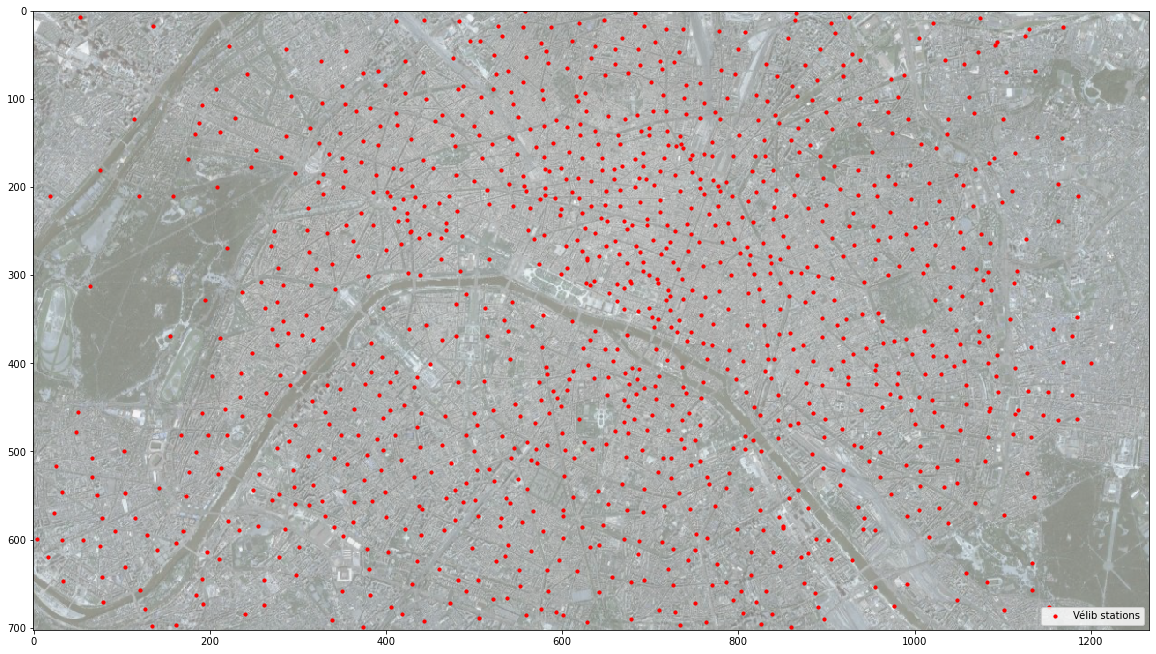

In [12]:
df = dfs[0]

PlotResults(dfs, img).single_plot(x=df['LAT'],
                                  y=df['LON'],
                                  color='red',
                                  dot_size=10,
                                  alpha=1,
                                  label='Vélib stations',
                                  title=None)

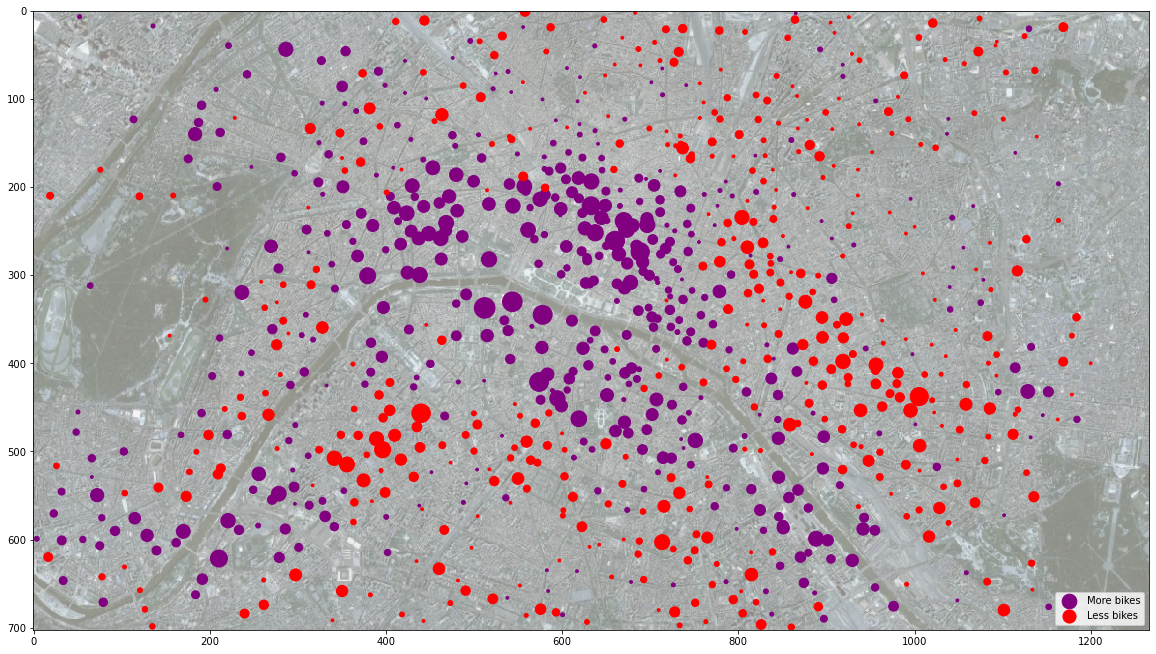

In [13]:
PlotResults(dfs, img).multiple_plot_slots()